# Self-Driving Car Engineer Nanodegree


## Project: Build a Traffic Sign Classifier

In [39]:
### Imports
import pickle
import os

import pandas as pd
import seaborn as sn
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import tensorflow as tf
from tensorflow.contrib.layers import flatten

## Load Dataset

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.  
**THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [2]:
# Load pickled data
training_file = './traffic-signs-data/train.p'
validation_file = './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    validation = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_validation, y_validation = validation['features'], validation['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
# Read class interpretation strings
class_descriptions = pd.read_csv("signnames.csv")

---

## Explore Dataset

### Dataset summary

In [4]:
### Display some data set metrics

# Number of training examples?
n_train = X_train.shape[0]

# Number of validation examples?
n_validation = X_validation.shape[0]

# Number of testing examples?
n_test = X_test.shape[0]

# What is the shape of a traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

# How many unique classes/labels there are in the dataset?
counts = Counter(y_train)
n_classes = len(counts.keys())

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

In [61]:
### Plot thumbnails in a grid
def plot_image_grid(image_data, index_array, images_per_row=10):

    # Create subplot grid
    no_of_rows = int(np.ceil(len(index_array) / images_per_row))
    fig, axarr = plt.subplots(no_of_rows, images_per_row, figsize=(2*images_per_row, 2*no_of_rows))
    if axarr.ndim == 1:
        axarr = np.expand_dims(axarr, axis=0)
    
    # Plot images in a grid
    for row in range(no_of_rows):
        for col in range(images_per_row):
            current_subplot = images_per_row*row+col
            if (current_subplot < len(index_array)):
                current_image = image_data[index_array[current_subplot]].squeeze()
                axarr[row, col].imshow(current_image, interpolation="nearest", cmap="gray")
            else:
                # All images are visible, hide bounding box
                axarr[row, col].axis('off')
            
            # Hide suplot axes
            axarr[row, col].get_xaxis().set_visible(False)
            axarr[row, col].get_yaxis().set_visible(False)

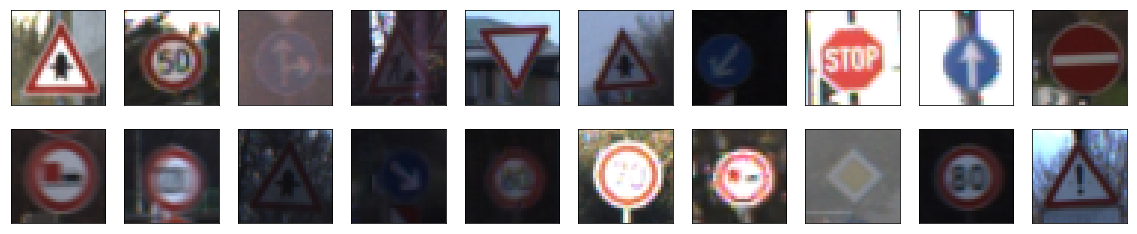

In [6]:
### Plot some random images from the training set
example_image_indices = np.random.randint(0, len(X_train), 20)
plot_image_grid(X_train, example_image_indices)

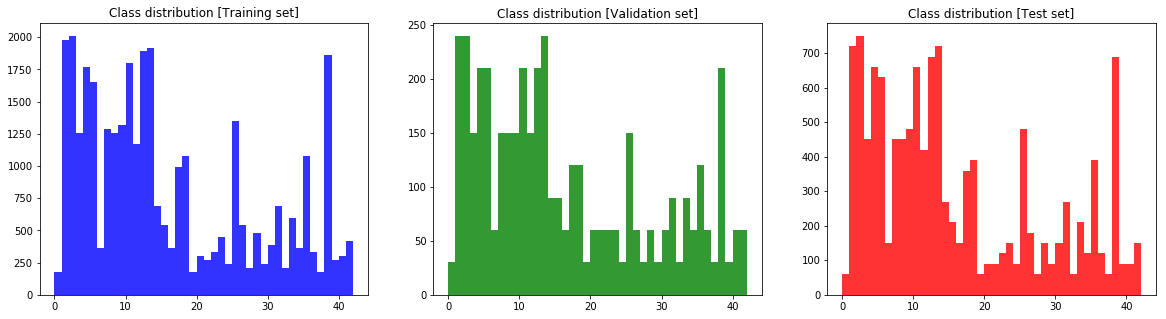

In [7]:
### Visualize class distribution in the different data sets
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(20, 5))

# Training set
ax0.hist(y_train, n_classes-1, histtype='stepfilled', facecolor='b', alpha=0.8)
ax0.set_title('Class distribution [Training set]')

# Validation set
ax1.hist(y_validation, n_classes-1, histtype='stepfilled', facecolor='g', alpha=0.8)
ax1.set_title('Class distribution [Validation set]')

# Test set
ax2.hist(y_test, n_classes-1, histtype='stepfilled', facecolor='r', alpha=0.8)
ax2.set_title('Class distribution [Test set]')

In [8]:
### Check which classes are most/least common
print("Most common classes: {}".format([class_descriptions.iloc[item[0], 1] for item in counts.most_common()[:3]]))
print("Most uncommon classes: {}".format([class_descriptions.iloc[item[0], 1] for item in counts.most_common()[-3:]]))

Most common classes: ['Speed limit (50km/h)', 'Speed limit (30km/h)', 'Yield']
Most uncommon classes: ['Speed limit (20km/h)', 'Dangerous curve to the left', 'Go straight or left']


### Data analysis

* Images are in the RGB colorspace.
* Images are cropped to show only the sign.
* Some images seems to have very imbalanced brightness.
* Classes are imbalanced, but have roughly the same distribution.
* Rather few examples.

----

## Data Augmentation

CNN training will benefit from more examples, so the training dataset should be augmented.  

* Brightness should be varied to make the model robust to different lighting conditions.
* Affine transformations are another good way of perturbing original images and make model more robust to perspective etc.

Augmentation also helps to avoid overfitting.

### Brightness adjustment

In [9]:
def apply_random_brightness(img):
    
    # Convert to HSV space, where brightness is controlled in the V-channel
    hsv_img = img
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(float)

    # Adjust V-value randomly
    hsv_img[:,:,2] *= np.random.uniform(0.3, 1.8)
    hsv_img = np.clip(hsv_img, 0, 255)

    # Return image to RGB
    return cv2.cvtColor(hsv_img.astype('uint8'), cv2.COLOR_HSV2RGB)

### Affine transformations

An affine transformation maintains parallel lines in a image. It can be expressed as a matrix operation.  
Typical examples are translation and rotation.

In [10]:
def apply_random_translation(img, max_translation=5):
    
    rows, cols, _ = img.shape
    
    # Translate in random direction (t_x, t_y)
    # Images are already cropped rather close to the traffic sign, so do not translate too much
    t_x = max_translation*np.random.uniform(-1.0, 1.0)
    t_y = max_translation*np.random.uniform(-1.0, 1.0)

    # The affine operator for translation is [1 0 t_x]
    #                                        [0 1 t_y]
    #
    affine_operator = np.float32([[1, 0, t_x],[0, 1, t_y]])
    
    return cv2.warpAffine(img, affine_operator, (cols, rows))

In [11]:
def apply_random_rotation(img, max_angle_deg=10):
    
    rows, cols, _ = img.shape
    
    # Rotate with random angle (in degrees)
    rotation_angle_deg = max_angle_deg*np.random.uniform(-1.0, 1.0)
    
    # Use OpenCV to get rotation matrix
    affine_operator = cv2.getRotationMatrix2D((cols/2,rows/2), rotation_angle_deg, 1)
    
    return cv2.warpAffine(img, affine_operator, (cols, rows))

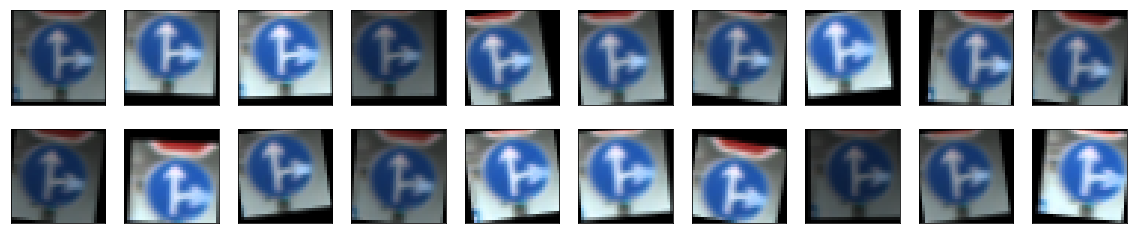

In [12]:
### Test data augmentation
test_image = X_train[1100]
augmented_set = np.empty((0, test_image.shape[0], test_image.shape[1], test_image.shape[2]), dtype='uint8')

for i in range(20):
    img = apply_random_brightness(test_image)
    img = apply_random_translation(img)
    img = apply_random_rotation(img)
    augmented_set = np.append(augmented_set, [img], axis=0)

plot_image_grid(augmented_set, np.arange(augmented_set.shape[0]))

----

## Data Pre-processing

### Pre-process the dataset

Images do not differ in color only, so it should be possible to use just one color channel. This will also have the benefit of reducing the number of parameters in the model.

In [13]:
def preprocess_image(img, colorspace = cv2.COLOR_RGB2GRAY, channel_to_use = 0):
    
    # Convert to requested colorspace
    img = cv2.cvtColor(img, colorspace)  
    
    # Check how many channels the new colorspace has 
    if len(img.shape) == 3:
        # Multichannel, extract channel to use
        img = img[:,:,channel_to_use]    
    
    # Improve contrast by local histogram equalization
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(2,2))
    img = clahe.apply(img)

    # Normalize image [-1, 1]
    img = img.astype(float)
    img = (img - 128.0)/128.0
    
    # Single channel used, but express in 3 dimensions to fit CNN model
    return np.expand_dims(img, -1)

In [14]:
def preprocess_image_dataset(dataset, labels, multiplier=20):
        
    # CNN model expects tensor of shape [batch_size, 32, 32, 1], since the pre-processor converts images to one channel
    # Extend dataset with factor given by <multiplier> using perturbed versions of the images
    preprocessed_dataset = np.zeros((dataset.shape[0]*(multiplier+1), 32, 32, 1), dtype=float)
    preprocessed_labels = np.zeros(labels.shape[0]*(multiplier+1), dtype='uint8')

    # Loop through each image in dataset and preprocess it
    for i in np.arange(dataset.shape[0]):
        
        # Preprocess original image
        preprocessed_dataset[(multiplier+1)*i] = preprocess_image(dataset[i])
        preprocessed_labels[(multiplier+1)*i] = labels[i]
        
        # Add preprocessed, perturbed versions of image
        for m in range(multiplier):
            preprocessed_dataset[(multiplier+1)*i+m+1] = create_perturbed_image(dataset[i])
            preprocessed_labels[(multiplier+1)*i+m+1] = labels[i]
        
    return preprocessed_dataset, preprocessed_labels

In [15]:
### Create perturbed versions of an image using the defined transformations
def create_perturbed_image(src_img):

    # Apply transforms
    image = apply_random_brightness(src_img)
    image = apply_random_translation(image)
    image = apply_random_rotation(image)
    
    # Apply preprocessor
    image = preprocess_image(image)
    
    return image

### Run preprocessors

In [16]:
# Preprocess and augment training dataset with a factor 5
X_train, y_train = preprocess_image_dataset(X_train, y_train, 5)
X_validation, y_validation = preprocess_image_dataset(X_validation, y_validation, 0)
X_test_prep, y_test_prep = preprocess_image_dataset(X_test, y_test, 0)

In [17]:
X_train.shape

(208794, 32, 32, 1)

----

## Model Architecture

### Define CNN based on LeNet

In [18]:
### Define input placeholders

# X, Y
x = tf.placeholder(tf.float32, (None, 32, 32, 1), name='x')
y = tf.placeholder(tf.int32, (None), name='y')
one_hot_y = tf.one_hot(y, n_classes)

# Keep probability for dropout layers
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

In [19]:
#### Define CNN, based on LeNet
def LeNet(x, keep_prob): 
    # Arguments used for tf.truncated_normal
    mu = 0
    sigma = 0.1
    
    # Layer parameters
    weights = {
        'wc1': tf.Variable(tf.truncated_normal([5, 5, 1, 6], mean = mu, stddev = sigma), name='wc1'),
        'wc2': tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean = mu, stddev = sigma), name='wc2'),
        'wfc1': tf.Variable(tf.truncated_normal([400, 512], mean = mu, stddev = sigma), name='wfc1'),
        'wfc2': tf.Variable(tf.truncated_normal([512, 256], mean = mu, stddev = sigma), name='wfc2'),
        'wfc3': tf.Variable(tf.truncated_normal([256, n_classes], mean = mu, stddev = sigma), name='wfc3') }

    biases = {
        'bc1': tf.Variable(tf.constant(0.1, shape=[6]), name='bc1'),
        'bc2': tf.Variable(tf.constant(0.1, shape=[16]), name='bc2'),
        'bfc1': tf.Variable(tf.constant(0.1, shape=[512]), name='bfc1'),
        'bfc2': tf.Variable(tf.constant(0.1, shape=[256]), name='bfc2'),
        'bfc3': tf.Variable(tf.constant(0.1, shape=[n_classes]), name='bfc3') }
    
    # Layer 1: Convolutional. Input = 32x32x1, Conv = 28x28x6, Output = 14x14x6
    conv1 = tf.nn.conv2d(x, weights['wc1'], strides=[1, 1, 1, 1], padding='VALID', name='conv1') + biases['bc1']
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')

    # Layer 2: Convolutional. Input = 14x14x6, Conv = 10x10x16, Output = 5x5x16.
    conv2 = tf.nn.conv2d(conv1, weights['wc2'], strides=[1, 1, 1, 1], padding='VALID', name='conv2') + biases['bc2']
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    
    # Layer 3: Fully Connected. Input = 400. Output = 512.
    fc1 = tf.contrib.layers.flatten(conv2)
    fc1 = tf.add(tf.matmul(fc1, weights['wfc1']), biases['bfc1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 512. Output = 256.
    fc2 = tf.add(tf.matmul(fc1, weights['wfc2']), biases['bfc2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 256. Output = 43.
    logits = tf.add(tf.matmul(fc2, weights['wfc3']), biases['bfc3'])
    
    return logits

### Train, Validate and Test the Model

In [20]:
### Define CNN hyperparameters
EPOCHS = 50
BATCH_SIZE = 256

lr = 0.001

# Regularization
keep_probability = 0.5

In [21]:
### Build CNN model
logits = LeNet(x, keep_prob)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = lr)
training_operation = optimizer.minimize(loss_operation)

In [22]:
### Operations for evaluating model
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
prediction_error_indices = tf.where(tf.logical_not(correct_prediction))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [23]:
### Calculate total accuracy on all batches in a dataset
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    error_indices = np.array([])
    sess = tf.get_default_session()
    
    # Iterate over batches
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        
        # Make sure dropout is 1.0 when evaluating
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})

        total_accuracy += (accuracy * len(batch_x))
                    
    return total_accuracy / num_examples

In [24]:
# Train model and save it
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        
        # Shuffle all examples first
        X_train, y_train = shuffle(X_train, y_train)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: keep_probability})
            
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './model/lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.774
Validation Accuracy = 0.855

EPOCH 2 ...
Training Accuracy = 0.890
Validation Accuracy = 0.920

EPOCH 3 ...
Training Accuracy = 0.935
Validation Accuracy = 0.940

EPOCH 4 ...
Training Accuracy = 0.954
Validation Accuracy = 0.957

EPOCH 5 ...
Training Accuracy = 0.965
Validation Accuracy = 0.963

EPOCH 6 ...
Training Accuracy = 0.971
Validation Accuracy = 0.969

EPOCH 7 ...
Training Accuracy = 0.975
Validation Accuracy = 0.960

EPOCH 8 ...
Training Accuracy = 0.979
Validation Accuracy = 0.968

EPOCH 9 ...
Training Accuracy = 0.983
Validation Accuracy = 0.975

EPOCH 10 ...
Training Accuracy = 0.984
Validation Accuracy = 0.972

EPOCH 11 ...
Training Accuracy = 0.987
Validation Accuracy = 0.978

EPOCH 12 ...
Training Accuracy = 0.984
Validation Accuracy = 0.971

EPOCH 13 ...
Training Accuracy = 0.990
Validation Accuracy = 0.974

EPOCH 14 ...
Training Accuracy = 0.988
Validation Accuracy = 0.972

EPOCH 15 ...
Training Accuracy = 0.992
Valid

---

## Evaluate model

### Test accuracy

In [25]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model/'))

    test_accuracy = evaluate(X_test_prep, y_test_prep)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.964


### Extra test images

To better understand model robustness, let's predict classes for a few random images of German traffic signs downloaded from the internet.  
The images have been cropped to box the traffic sign, similar to the images in the original dataset.

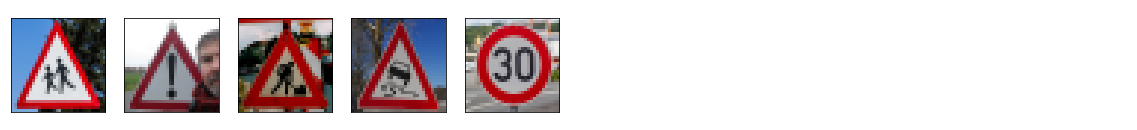

In [47]:
### Load the images and plot them
test_images_dir = "./test_images_cropped/"
X_test_images = np.empty((0, 32, 32, 3), dtype='uint8')

## Loop through test images
for current_image_filename in os.listdir(test_images_dir):
    path_to_image = os.path.join(test_images_dir, current_image_filename)
    
    if (path_to_image.endswith(".jpg")):
        if (os.path.isfile(path_to_image)):
            
            # Read image (BGR space)
            current_image = cv2.imread(path_to_image)
            current_image = cv2.cvtColor(current_image, cv2.COLOR_BGR2RGB)

            # Resize image to 32x32
            # Use CV_INTER_AREA = 3 interpolation for downsizing
            current_image = cv2.resize(current_image, (32, 32), interpolation=3) 

            ## Add image to batch
            X_test_images = np.append(X_test_images, [current_image], axis=0)
            
# Plot test images
plot_image_grid(X_test_images, np.arange(X_test_images.shape[0]))

In [27]:
### According to the signnames.csv, the test images have the following labels:

# Children crossing = 28
# General caution = 18
# Roadwork = 25
# Slippery road = 23
# Speed limit 30 km/h = 1
y_test_images = np.array([28, 18, 25, 23, 1])

#### Pre-processing pipeline

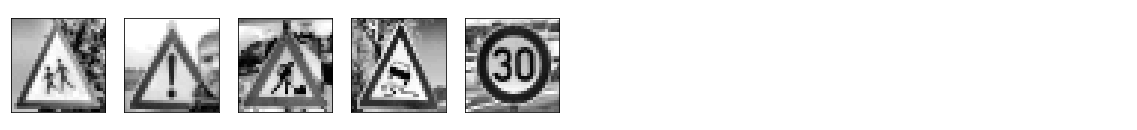

In [28]:
### Run image preprocessing pipeline
X_test_images_prep, _ = preprocess_image_dataset(X_test_images, y_test_images, 0)

# Plot preprocessed test images
plot_image_grid(X_test_images_prep, np.arange(X_test_images.shape[0]))

#### Class predictions

In [29]:
### Get model logits for the test images and the prediction accuracy

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model'))

    # Make sure dropout is 1.0 when evaluating
    test_image_logits, test_image_accuracy = sess.run([logits, accuracy_operation], 
                                                      feed_dict={x: X_test_images_prep, y: y_test_images, keep_prob: 1.0})
    
    # Details of top k probabilities
    top_k = sess.run(tf.nn.top_k(tf.nn.softmax(test_image_logits), k=5))

In [30]:
# Class predictions
print("True classes           : {}".format(y_test_images))
print("Predicted image classes: {}".format(np.argmax(test_image_logits, 1)))

# Accuracy
print("Accuracy on test images = {}\n".format(test_image_accuracy))

# Details of top k probabilities
print(top_k)

True classes           : [28 18 25 23  1]
Predicted image classes: [28 18 25 23  1]
Accuracy on test images = 1.0

TopKV2(values=array([[  9.99999642e-01,   3.43892481e-07,   3.73890821e-08,
          5.55018786e-09,   3.82967524e-09],
       [  1.00000000e+00,   2.58599447e-10,   8.35967173e-18,
          2.07599483e-18,   8.92879960e-29],
       [  9.99715149e-01,   2.33434592e-04,   4.03561753e-05,
          9.47624267e-06,   8.79059826e-07],
       [  1.00000000e+00,   1.05712277e-20,   2.29772922e-21,
          8.93595279e-22,   4.88488863e-24],
       [  1.00000000e+00,   5.14284693e-24,   6.62938490e-26,
          5.04791015e-27,   3.18811050e-36]], dtype=float32), indices=array([[28, 29, 11, 24, 27],
       [18, 26, 24, 27, 11],
       [25, 30, 29, 24, 20],
       [23, 31, 29, 30, 19],
       [ 1,  2,  5,  0,  4]], dtype=int32))


#### Prediction certainties

In [31]:
def plot_prediction_certainty(axis, n, top_k):

    # Extract predicted classes and probabilities, sort so top class is placed at the top of the plot
    classes = top_k.indices[n][::-1]
    probabilities = top_k.values[n][::-1]
    
    # Plot top k class probabilities
    pos = np.arange(len(top_k.indices))
    
    axis.barh(pos, probabilities, alpha=0.8)
    axis.set_xlim(0, 1)
    axis.set_yticks(pos)
    axis.set_yticklabels(class_descriptions.iloc[classes, 1])
    axis.set_title("Predicted classes image {}".format(n+1))

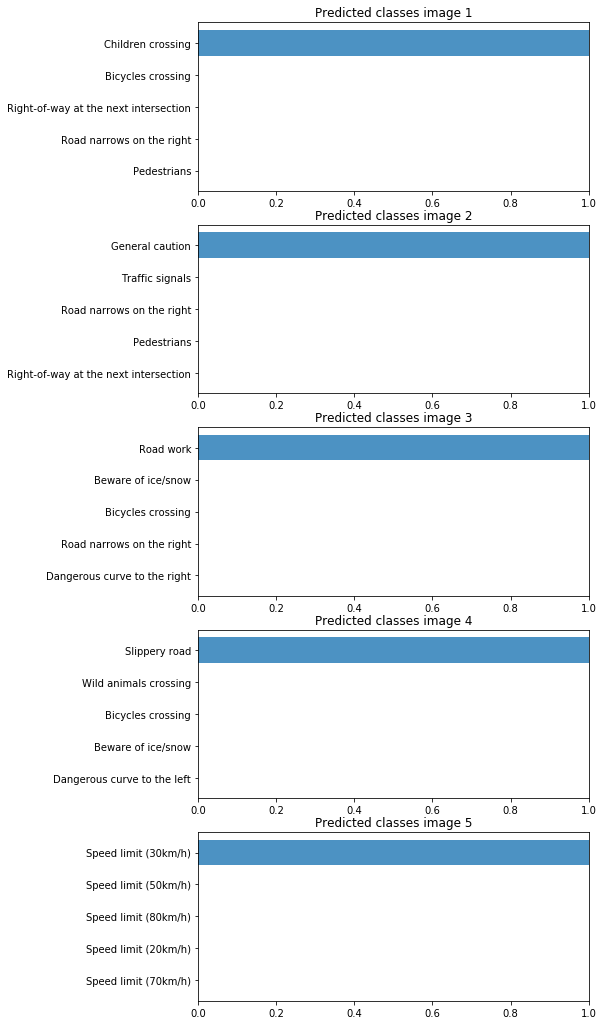

In [56]:
### Plot prediction certainties for the extra test images
fig, axes = plt.subplots(nrows=X_test_images.shape[0], figsize=(7, 18))

for n in np.arange(X_test_images.shape[0]):
    plot_prediction_certainty(axes[n], n, top_k)

The classifier is pretty certain about the class for all the test images!

### Misclassifications
Inspect some misclassified images in the test set.

#### Misclassified images inspection

In [57]:
def get_misclassified_images(X_data, y_data):
    
    num_examples = len(X_data)
    error_indices = np.array([], dtype=int)
    all_logits = np.empty((0, 43), dtype=float)
    sess = tf.get_default_session()
    
    # Iterate over batches
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        
        # Make sure dropout is 1.0 when evaluating
        batch_errors, batch_logits = sess.run([prediction_error_indices, logits], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        batch_errors = np.asarray(batch_errors).astype(int).squeeze()
        batch_logits = batch_logits.squeeze()
        
        # Adjust indices of batch to refer to complete dataset
        batch_errors += offset
            
        error_indices = np.append(error_indices, batch_errors)
        all_logits = np.append(all_logits, batch_logits, axis=0)
            
    return error_indices, all_logits

In [58]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model/'))
    pred_err_idx, all_test_logits = get_misclassified_images(X_test_prep, y_test_prep)

Plot some examples of misclassified images:

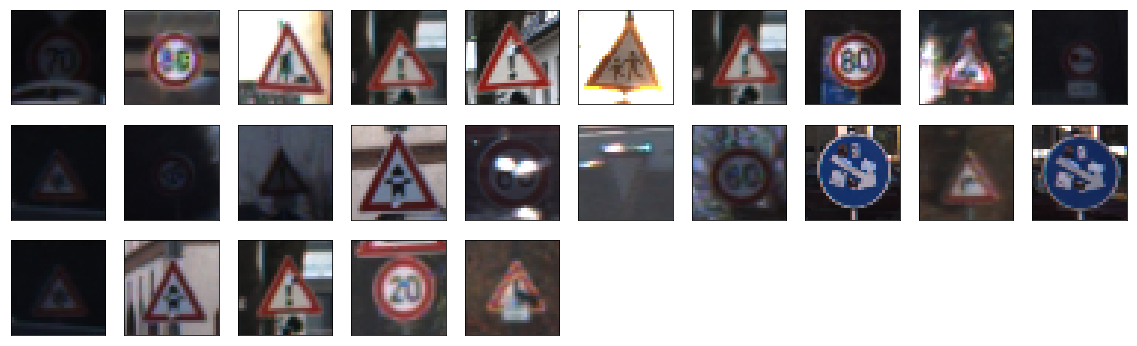

In [60]:
# Original images
plot_image_grid(X_test, pred_err_idx[-25:])

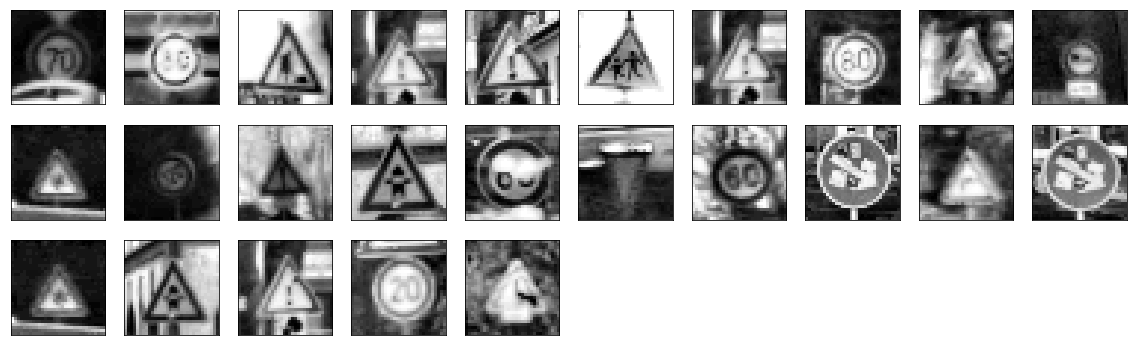

In [36]:
# Pre-processed images
plot_image_grid(X_test_prep, pred_err_idx[-25:])

Some misclassified images have glares and other artefacts across the traffic signs. Other are very blurry. Image processing could perhaps be improved to correctly classify them as well.

#### Confusion matrix
Check the confusion matrix to understand which classes are most commonly confused by the model.

In [37]:
# Model predictions on entire test set
y_test_predictions = np.argmax(all_test_logits, axis=-1)

# Create confusion matrix
cm = confusion_matrix(y_test_prep, y_test_predictions)

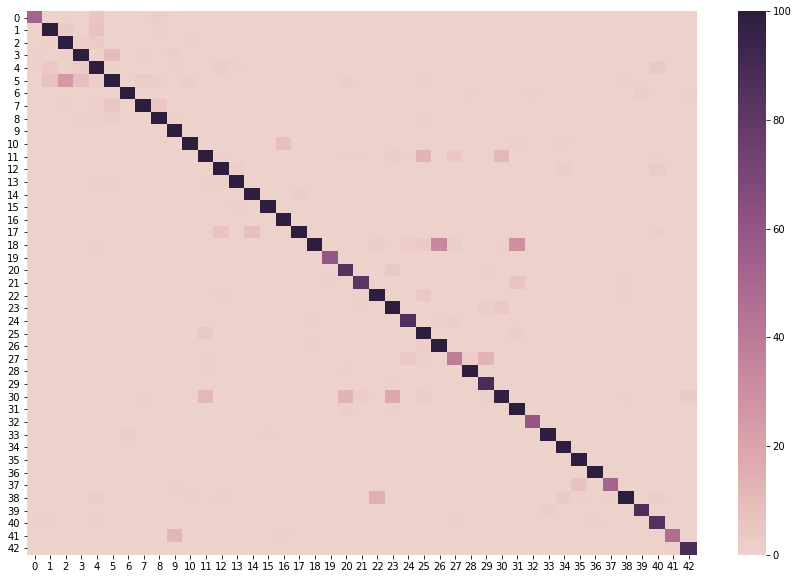

In [42]:
# Plot confusion matrix
colormap = sn.cubehelix_palette(as_cmap=True)
plt.figure(figsize = (15,10))

sn.heatmap(cm, vmax=100, cmap=colormap)

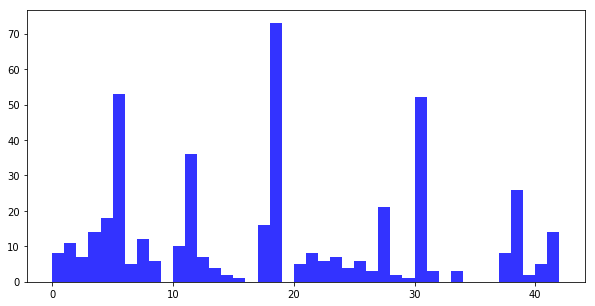

In [63]:
### Visualize class distribution of misclassification
plt.figure(figsize = (10,5))
_ = plt.hist(y_test_prep[pred_err_idx], n_classes-1, normed=False, histtype='stepfilled', facecolor='b', alpha=0.8)

The top three classes that are confused turns out to be:
* General caution
* Speed limit 80 km/h
* Beware of ice and snow

---

## Visualize Neural Network State

In [79]:
### Visualize CNN feature maps

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, keep_prob: 1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        plt.axis('off')
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="spline16", vmin =activation_min, vmax=activation_max, cmap="inferno")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="spline16", vmax=activation_max, cmap="inferno")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="spline16", vmin=activation_min, cmap="inferno")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="spline16", cmap="inferno")

In [90]:
def display_image_feature_maps(test_image_no, plot_start=1):
    
    # Pick a image to trace
    #test_image_no = 4
    trace_image = X_test_images[test_image_no]
    plt.figure(plot_start)
    plt.imshow(trace_image)
    plt.axis('off')
    trace_image = np.expand_dims(X_test_images_prep[test_image_no], axis=0)

    # Plot feature maps for first convolutional layer
    conv1_var = tf.get_default_graph().get_tensor_by_name("conv1:0")
    outputFeatureMap(trace_image, conv1_var, plt_num=plot_start+1)

    # Plot feature maps for second convolutional layer
    conv2_var = tf.get_default_graph().get_tensor_by_name("conv2:0")
    outputFeatureMap(trace_image, conv2_var, plt_num=plot_start+2)

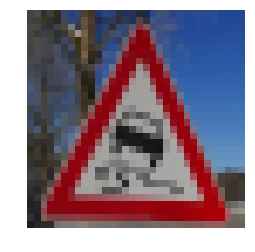

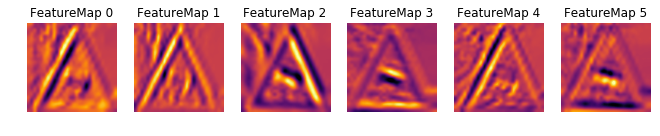

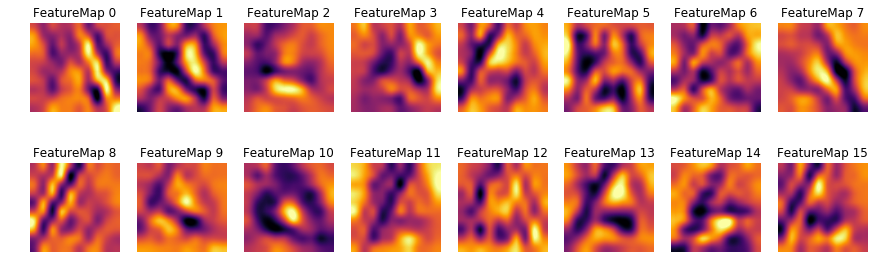

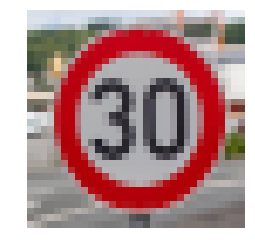

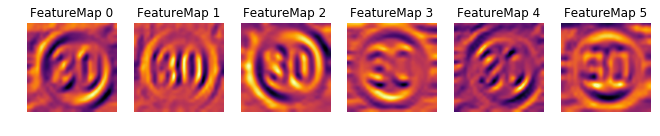

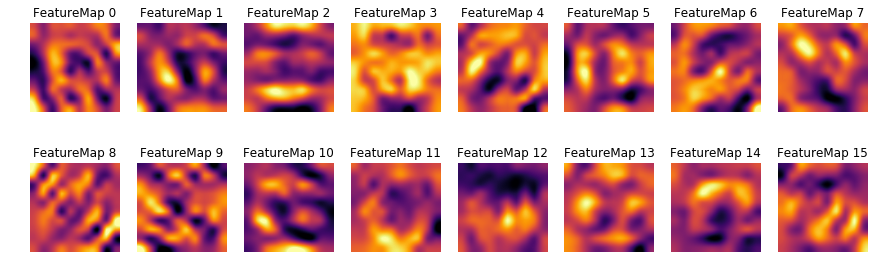

In [91]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./model/'))

    display_image_feature_maps(3, 1)
    display_image_feature_maps(4, 4)

Plotting the feature maps for a few examples reveals that the network has learnt to detect edges at the lower levels and then the sign shapes.